In [1]:
import sweetviz as sv
import pandas as pd

# Load your dataset (for example, unseen_data)
unseen_data = pd.read_csv("predicted_semester_gpa.csv")

# Generate the report
report = sv.analyze(unseen_data)

# Show the report in Jupyter notebook (if you're using one)
report.show_html("eda_report.html")

                                             |                                                                …

Report eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import mutual_info_regression, RFE, SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset
file_path = "predicted_semester_gpa.csv"
df = pd.read_csv(file_path)
dftemp= df.copy()
df1 = df.copy()

# Display basic info and first few rows
print(df.info())  # Check column data types and missing values
print(df.head())  # See sample data
print(df1.head())
print("Null values present or not:")
print(df.isnull().sum())  # Count missing values


import warnings
import logging

warnings.filterwarnings("ignore")  # Ignore warnings

# Suppress logging for LightGBM
logging.getLogger("lightgbm").setLevel(logging.ERROR)

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define folder path
output_folder = "plots"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

import joblib
from scipy.stats import skew

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Registration Number              3200 non-null   object 
 1   Specialization                   3200 non-null   object 
 2   Branch                           3200 non-null   object 
 3   Last Semester                    3200 non-null   int64  
 4   Attendance (%)                   3200 non-null   int64  
 5   CGPA                             3200 non-null   float64
 6   Semester GPA (Target)            3200 non-null   float64
 7   Backlogs                         3200 non-null   int64  
 8   Midterm Scores (out of 50)       3200 non-null   object 
 9   Grades (S, A, B, C, D, E, F, N)  3200 non-null   object 
 10  Study Hours/Day                  3200 non-null   float64
 11  Club Membership                  3200 non-null   object 
 12  Club Hours/Week     

Applying Log Transform to skewed features: ['Leadership Role']


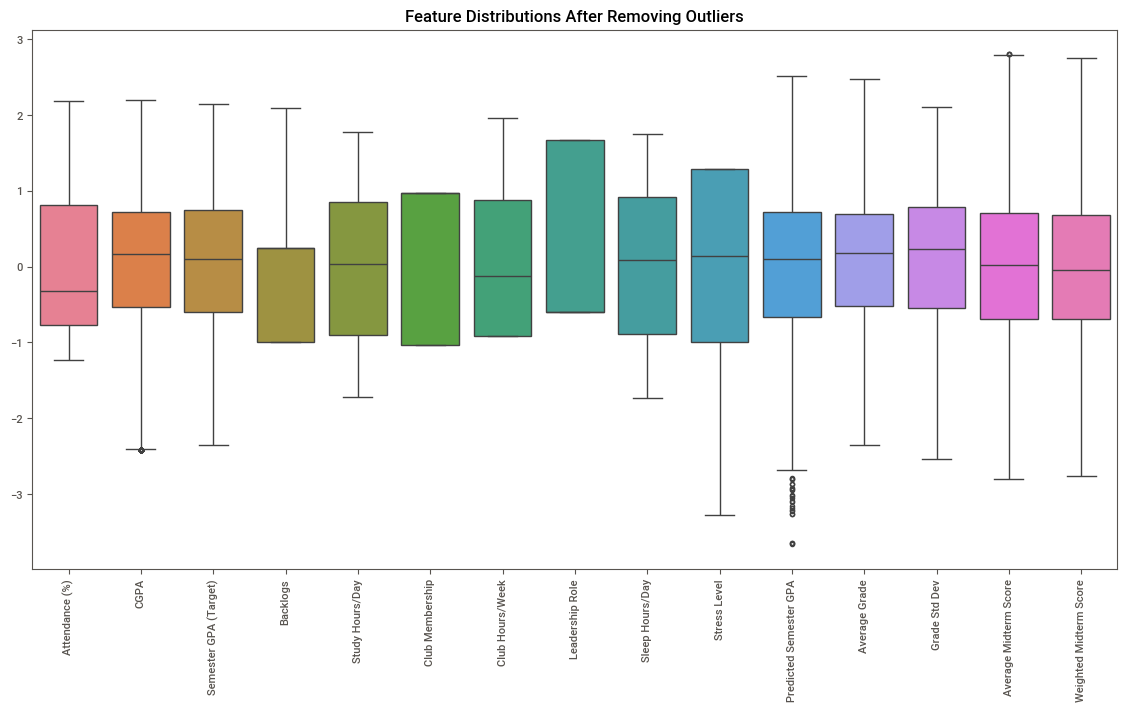

⚠️ Highly correlated features detected (r > 0.85):
🔹 CGPA ↔ Semester GPA (Target) (r=0.92)
🔹 CGPA ↔ Average Grade (r=0.95)
🔹 Semester GPA (Target) ↔ CGPA (r=0.92)
🔹 Semester GPA (Target) ↔ Average Grade (r=0.87)
🔹 Club Membership ↔ Club Hours/Week (r=0.89)
🔹 Club Hours/Week ↔ Club Membership (r=0.89)
🔹 Average Grade ↔ CGPA (r=0.95)
🔹 Average Grade ↔ Semester GPA (Target) (r=0.87)
🔹 Average Midterm Score ↔ Weighted Midterm Score (r=0.90)
🔹 Weighted Midterm Score ↔ Average Midterm Score (r=0.90)
🔸 Features with weak correlation to Semester GPA (Target): ['Club Membership', 'Club Hours/Week', 'Leadership Role', 'Sleep Hours/Day']


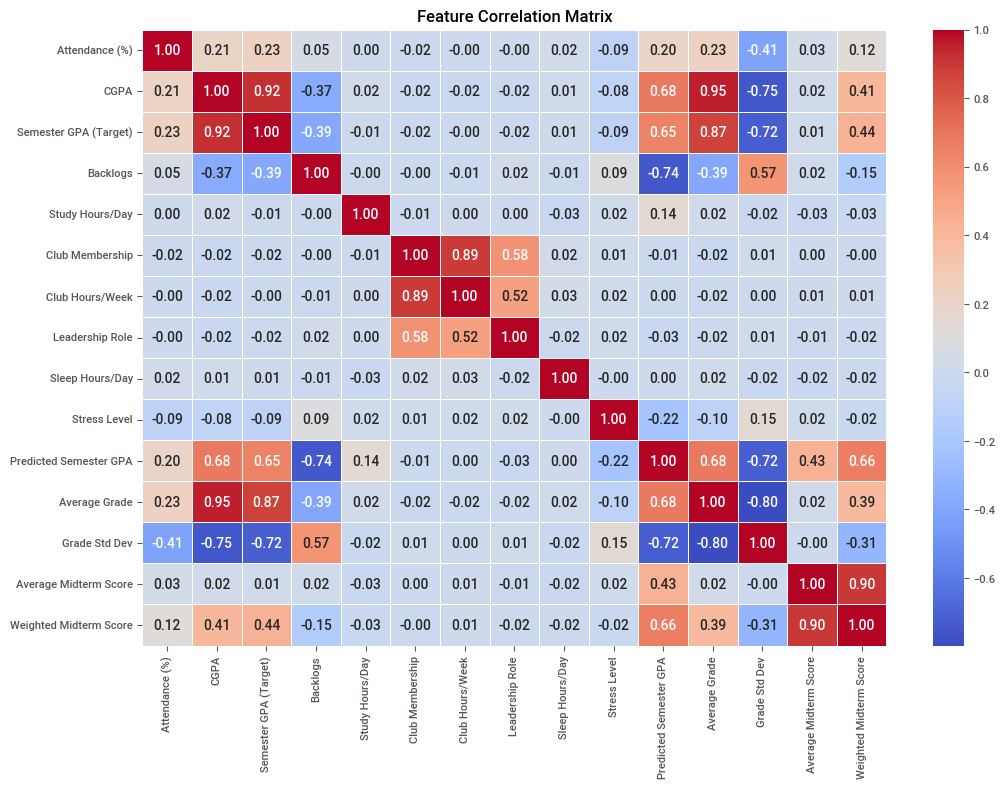

Predicted Semester GPA    1.000000
Average Grade             0.680149
CGPA                      0.677915
Weighted Midterm Score    0.662561
Semester GPA (Target)     0.647217
Average Midterm Score     0.434707
Attendance (%)            0.204299
Study Hours/Day           0.144791
Sleep Hours/Day           0.003688
Club Hours/Week           0.000584
Club Membership          -0.013830
Leadership Role          -0.025550
Stress Level             -0.217348
Grade Std Dev            -0.719979
Backlogs                 -0.743936
Name: Predicted Semester GPA, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Attendance (%)          3200 non-null   float64
 1   CGPA                    3200 non-null   float64
 2   Semester GPA (Target)   3200 non-null   float64
 3   Backlogs                3200 non-null   float64
 4   

In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import ast
import os

# Drop unnecessary columns
df.drop(columns=["Registration Number", "Specialization", "Branch", "Last Semester"], inplace=True)
# Drop "Predicted Semester GPA" later after analysis

# ==============================
# Feature Processing
# ==============================

# Encode binary categorical features
df['Club Membership'] = df['Club Membership'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)
df['Leadership Role'] = df['Leadership Role'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

# Ensure Semester GPA (Target) is capped at 10
df['Semester GPA (Target)'] = df['Semester GPA (Target)'].clip(upper=10.0)

# Process Grades
def process_grades(grade_list):
    grade_mapping = {'S': 10, 'A': 9, 'B': 8, 'C': 7, 'D': 6, 'E': 5, 'F': 0, 'N': 0}
    grades = ast.literal_eval(grade_list) if isinstance(grade_list, str) else grade_list
    grades = [grade_mapping[g] for g in grades]
    return np.mean(grades), np.std(grades)

df[['Average Grade', 'Grade Std Dev']] = df['Grades (S, A, B, C, D, E, F, N)'].apply(lambda x: pd.Series(process_grades(x)))
df.drop(columns=['Grades (S, A, B, C, D, E, F, N)'], inplace=True)

# Process Midterm Scores
def process_midterms(midterm_list, target_gpa):
    scores = ast.literal_eval(midterm_list) if isinstance(midterm_list, str) else midterm_list
    avg_midterm = np.mean(scores)
    target_gpa = float(target_gpa)
    weighted_midterm = np.sum(scores) * target_gpa / len(scores)
    return avg_midterm, weighted_midterm

df[['Average Midterm Score', 'Weighted Midterm Score']] = df.apply(
    lambda row: pd.Series(process_midterms(row['Midterm Scores (out of 50)'], row['Semester GPA (Target)'])), axis=1
)

df.drop(columns=['Midterm Scores (out of 50)'], inplace=True)

# ==============================
# Handle Outliers Using IQR
# ==============================

def remove_outliers_iqr(df, columns, factor=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

# Apply IQR filtering to numerical features
numerical_features = ['Attendance (%)', 'CGPA', 'Semester GPA (Target)', 'Backlogs',
                      'Study Hours/Day', 'Sleep Hours/Day', 'Stress Level',
                      'Club Hours/Week', 'Average Midterm Score', 'Weighted Midterm Score',
                      'Average Grade', 'Grade Std Dev','Club Membership','Leadership Role']#, 'Predicted Semester GPA']

df = remove_outliers_iqr(df, numerical_features, factor=1.5)

# ==============================
# Feature Scaling & Skewness Handling
# ==============================

scaler = StandardScaler()
target_scaler = StandardScaler()

# Identify skewed features
numerical_features = ['Attendance (%)', 'CGPA', 'Semester GPA (Target)', 'Backlogs',
                      'Study Hours/Day', 'Club Membership', 'Club Hours/Week', 'Leadership Role', 'Sleep Hours/Day', 'Stress Level',
                      'Average Grade', 'Grade Std Dev', 'Average Midterm Score', 'Weighted Midterm Score']

skewed_features = [col for col in numerical_features if abs(skew(df[col])) > 1]
if skewed_features:
    print(f"Applying Log Transform to skewed features: {skewed_features}")
    df[skewed_features] = np.log1p(df[skewed_features])

# Apply Standard Scaling to numerical features only.
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Scale the target variable separately
df['Predicted Semester GPA'] = target_scaler.fit_transform(df[['Predicted Semester GPA']])

# Save scaler
joblib.dump(scaler, "scaler.pkl")
joblib.dump(target_scaler, "target_scaler.pkl")

# Save selected features
selected_features = df.columns.tolist()
selected_features.remove('Predicted Semester GPA')
joblib.dump(selected_features, "selected_features.pkl")

encoding_dict = {
    'Club Membership': {'Yes': 1, 'No': 0},
    'Leadership Role': {'Yes': 1, 'No': 0}
}
joblib.dump(encoding_dict, "encoding_dict.pkl")

# ==============================
# Feature Distributions & Correlation Analysis
# ==============================

# Plot Feature Distributions After Removing Outliers
plt.figure(figsize=(14, 7))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Feature Distributions After Removing Outliers")
plt.savefig(os.path.join(output_folder, "feature_distributions_after_removing_outliers.png"), dpi=300, bbox_inches="tight")
plt.show()

# Compute Correlation Matrix
corr_matrix = df.corr()

# Identify highly correlated features (r > 0.85)
high_corr_features = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and abs(corr_matrix[i][j]) > 0.85]
if high_corr_features:
    print("⚠️ Highly correlated features detected (r > 0.85):")
    for pair in high_corr_features:
        print(f"🔹 {pair[0]} ↔ {pair[1]} (r={corr_matrix[pair[0]][pair[1]]:.2f})")

# Identify weakly correlated features with target
weak_corr_features = [col for col in df.columns if abs(corr_matrix[col]['Predicted Semester GPA']) < 0.1]
if weak_corr_features:
    print(f"🔸 Features with weak correlation to Semester GPA (Target): {weak_corr_features}")

# Plot Feature Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.savefig(os.path.join(output_folder, "feature_correlation_matrix.png"), dpi=300, bbox_inches="tight")
plt.show()
print(corr_matrix["Predicted Semester GPA"].sort_values(ascending=False))

# Summary of dataset
print(df.info())
print(df.head())

   Attendance (%)      CGPA  Semester GPA (Target)  Backlogs  Study Hours/Day  \
0        1.613844  0.485985               0.521391  0.240297        -0.786304   
1       -0.890611 -0.652483              -0.490432  0.240297        -0.436852   
2        0.816972  0.518206               0.195359  0.240297         0.844473   
3       -0.776772  0.443024               0.498906 -0.994967         0.262053   
4       -1.232128  0.797453               0.881150  0.240297         1.310410   

   Club Membership  Club Hours/Week  Leadership Role  Sleep Hours/Day  \
0        -1.031109        -0.919092        -0.598527         0.777719   
1         0.969830         1.202131        -0.598527         1.334943   
2         0.969830         1.345943         1.670769        -1.729789   
3         0.969830         0.195449         1.670769        -1.729789   
4         0.969830         0.662837         1.670769        -0.754647   

   Stress Level  Average Grade  Grade Std Dev  Average Midterm Score  \
0 

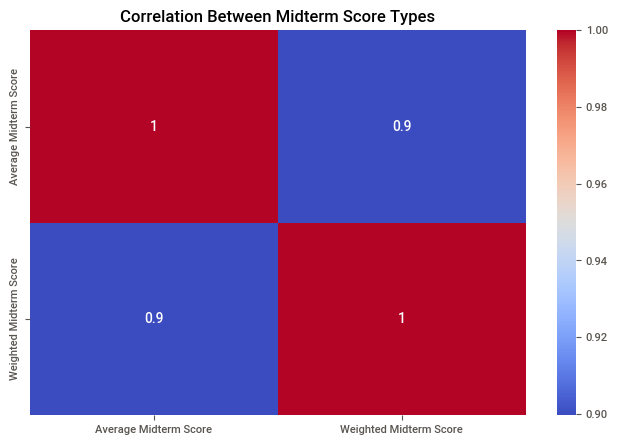

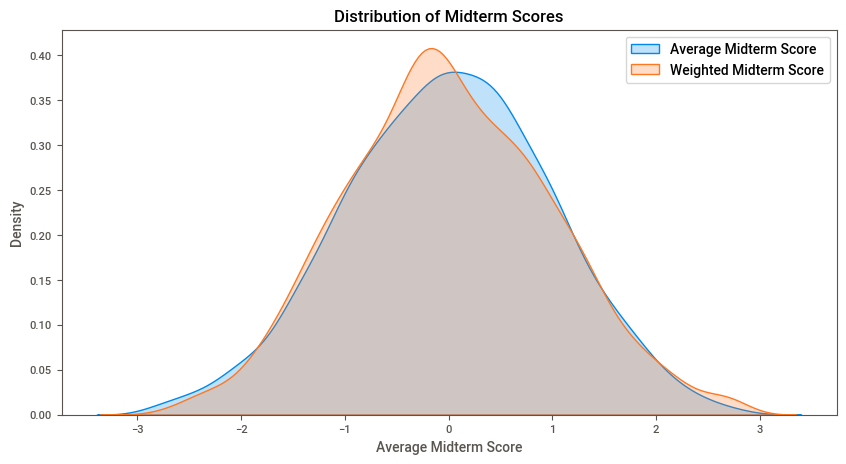


✅ PCA feature names saved successfully!

✅ All required data has been saved successfully!


In [4]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# ==============================
# Step 3: Feature Aggregation
# ==============================

# Load Data (Assumption: df is already defined)
#scaler = StandardScaler()

target = "Predicted Semester GPA"
X = df.drop(columns=[target])  # Drop target from features
# Reshape the target 'y' to a 2D array (n_samples, 1)
y = df[target].values.reshape(-1, 1)

# Save the scaler
#joblib.dump(scaler, "y_scaler.pkl")

print(X.head())
print(y[:5])
print("Number of Features in X:", X.shape[1])
print("Number of Features in Y:", y.shape)

# ==============================
# Feature Selection Methods
# ==============================

correlation_threshold = 0.1
correlations = X.corrwith(pd.Series(y.flatten(), index=df.index)).abs()
correlated_features = correlations[correlations > correlation_threshold].index.tolist()

# Mutual Information
mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
selected_features_mi = list(mi_series.index[:15])

# Recursive Feature Elimination (RFE)
rfe_model = RFE(estimator=LinearRegression(), n_features_to_select=15)
rfe_model.fit(X, y)
selected_features_rfe = X.columns[rfe_model.support_].tolist()

# Sequential Feature Selection (SFS)
sfs_n_features = min(10, X.shape[1])
sfs_model = SequentialFeatureSelector(LinearRegression(), n_features_to_select=sfs_n_features)
sfs_model.fit(X, y)
selected_features_sfs = X.columns[sfs_model.get_support()].tolist()

# RandomForest Feature Importance
tree_model = RandomForestRegressor(n_estimators=100, random_state=42)
tree_model.fit(X, y)
feature_importance = pd.Series(tree_model.feature_importances_, index=X.columns).sort_values(ascending=False)
selected_features_tree = feature_importance.index[:15].tolist()

# Lasso Regression
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X, y)
lasso_selected = np.abs(lasso_model.coef_) > 0
selected_features_lasso = X.columns[lasso_selected].tolist()

# Principal Component Analysis (PCA)
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X)
pca_features = [f"PCA_{i}" for i in range(X_pca.shape[1])]

# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
poly_features = poly.get_feature_names_out(X.columns)

# ==============================
# Feature Selection Comparison
# ==============================

feature_sets = {
    "Correlation": correlated_features,
    "Mutual Information": selected_features_mi,
    "RFE": selected_features_rfe,
    "SFS": selected_features_sfs,
    "Tree-based": selected_features_tree,
    "Lasso": selected_features_lasso,
    "PCA": pca_features,
    "Polynomial": list(poly_features[:15])
}

# Find common important features
common_features = set(selected_features_mi) & set(selected_features_rfe) & set(selected_features_sfs)

# Display Results
print("\n\n================= Feature Selection Results =================\n")
print("\nCommon Important Features Across Methods:", common_features)
print("\nFeature Selection Summary:")
for method, features in feature_sets.items():
    print(f"\n\U0001F4D9 {method} (Top Features):\n{features}")

# Display Feature Importance Scores
print("\nRandom Forest Feature Importances:")
print(feature_importance.head(20))

# ==============================
# Correlation Analysis for Midterms
# ==============================
plt.figure(figsize=(8, 5))
sns.heatmap(X[["Average Midterm Score", "Weighted Midterm Score"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Midterm Score Types")
plt.show()

# Distribution Plot Comparison
plt.figure(figsize=(10, 5))
sns.kdeplot(X["Average Midterm Score"], label="Average Midterm Score", shade=True)
sns.kdeplot(X["Weighted Midterm Score"], label="Weighted Midterm Score", shade=True)
plt.legend()
plt.title("Distribution of Midterm Scores")
plt.show()

# ==============================
# Save Important Data for Later Use
# ==============================

# Save Feature Selection Results
joblib.dump(feature_sets, "feature_selection.pkl")

# Save Mutual Information Scores
joblib.dump(mi_scores, "mutual_info_scores.pkl")

# Save Random Forest Feature Importances
joblib.dump(feature_importance, "random_forest_importance.pkl")

# Save PCA Model
joblib.dump(pca, "pca_model.pkl")

# Save Polynomial Transformer
joblib.dump(poly, "poly_transform.pkl")

# Save PCA Feature Names
pca_feature_names = [f"PCA_{i}" for i in range(pca.n_components_)]
joblib.dump(pca_feature_names, "pca_feature_names.pkl")

print("\n✅ PCA feature names saved successfully!")
print("\n✅ All required data has been saved successfully!")

In [5]:
final_selected_features = ['Attendance (%)', 'CGPA', 'Semester GPA (Target)', 'Backlogs',
                          'Study Hours/Day', 'Sleep Hours/Day', 'Stress Level', 
                          'Club Hours/Week', 'Average Midterm Score', 'Weighted Midterm Score',
                          'Average Grade', 'Grade Std Dev', 'Club Membership', 'Leadership Role']

print(f"final_selected_features length: {len(final_selected_features)}")
joblib.dump(final_selected_features, "final_selected_features.pkl")

final_selected_features length: 14


['final_selected_features.pkl']

⚠️ Highly correlated features detected (r > 0.85):
🔹 CGPA ↔ Semester GPA (Target) (r=0.92)
🔹 CGPA ↔ Average Grade (r=0.95)
🔹 Semester GPA (Target) ↔ CGPA (r=0.92)
🔹 Semester GPA (Target) ↔ Average Grade (r=0.87)
🔹 Club Membership ↔ Club Hours/Week (r=0.89)
🔹 Club Hours/Week ↔ Club Membership (r=0.89)
🔹 Average Grade ↔ CGPA (r=0.95)
🔹 Average Grade ↔ Semester GPA (Target) (r=0.87)
🔹 Average Midterm Score ↔ Weighted Midterm Score (r=0.90)
🔹 Weighted Midterm Score ↔ Average Midterm Score (r=0.90)


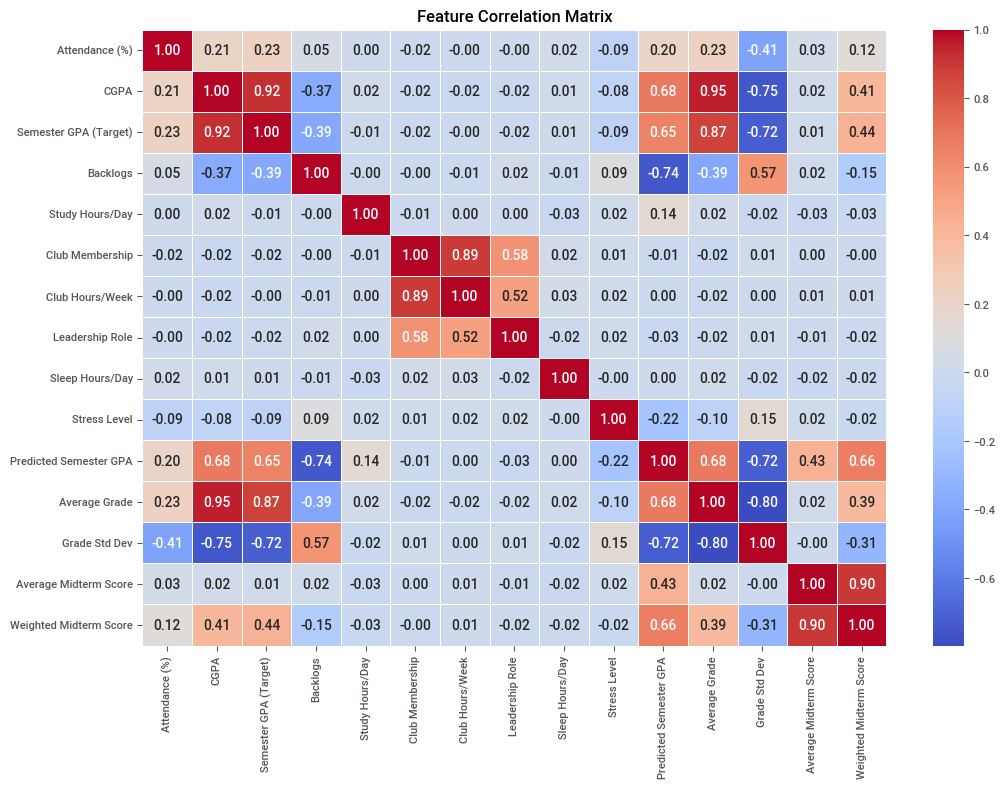

✅ Final Number of Features in X: 14
✅ Number of Samples: 3200
✅ Target Variable Shape: (3200, 1)


In [6]:
# Extract X and y
X = df[final_selected_features]
#y = df['Predicted Semester GPA']

# Save X and y for future use
X.to_csv("final_X.csv", index=False)
pd.Series(y.flatten(), name="Predicted Semester GPA").to_csv("final_y.csv", index=False)

# ==============================
# Summary & Correlation Analysis
# ==============================

# Compute Correlation Matrix
corr_matrix = df.corr()

# Identify highly correlated features (r > 0.85)
high_corr_features = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and abs(corr_matrix[i][j]) > 0.85]
if high_corr_features:
    print("⚠️ Highly correlated features detected (r > 0.85):")
    for pair in high_corr_features:
        print(f"🔹 {pair[0]} ↔ {pair[1]} (r={corr_matrix[pair[0]][pair[1]]:.2f})")

# Plot Feature Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Final Summary
print(f"✅ Final Number of Features in X: {X.shape[1]}")
print(f"✅ Number of Samples: {X.shape[0]}")
print(f"✅ Target Variable Shape: {y.shape}")

In [7]:
# ==========================
# 📌 Step 1: Train-Test Split
# ==========================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ Load the final selected features dataset
X = pd.read_csv("final_X.csv")
y = pd.read_csv("final_y.csv").values.ravel()  # Convert y to 1D array

# ✅ Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ X_train Shape: {X_train.shape}")
#print(f"✅ X_train Head: {X_train.head()}")

print(f"✅ X_test Shape: {X_test.shape}")
#print(f"✅ X_test Head: {X_test.head()}")

print(f"✅ y_train Shape: {y_train.shape}")
#print(f"✅ y_train Head: {y_train.head()}")

print(f"✅ y_test Shape: {y_test.shape}")
#print(f"✅ y_test Head: {y_test.head()}")

# =======================================
# 📌 Step 2: Feature Scaling (Standardize)
# =======================================

# # Load the previously saved scaler
# scaler = joblib.load("scaler.pkl")

# # Apply transformation
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Convert back to DataFrame
# X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
# X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

# ✅ Save the processed train & test sets for later use
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
pd.DataFrame(y_train, columns=["y_train"]).to_csv("y_train.csv", index=False)
pd.DataFrame(y_test, columns=["y_test"]).to_csv("y_test.csv", index=False)

print("✅ Data Split & Scaling Completed! 🚀")


✅ X_train Shape: (2560, 14)
✅ X_test Shape: (640, 14)
✅ y_train Shape: (2560,)
✅ y_test Shape: (640,)
✅ Data Split & Scaling Completed! 🚀


In [8]:
# Check the first few rows of X_train (features)
print("X_train (Features):")
print(X[:5])  # Show first 5 rows of X_train

# Check the first few rows of y_train (target)
print("\ny_train (Target):")
print(y[:5])  # Show first 5 rows of y_train

# To see the shape (dimensions) of X_train and y_train
print("\nX_train shape:", X.shape)
print("y_train shape:", y.shape)


X_train (Features):
   Attendance (%)      CGPA  Semester GPA (Target)  Backlogs  Study Hours/Day  \
0        1.613844  0.485985               0.521391  0.240297        -0.786304   
1       -0.890611 -0.652483              -0.490432  0.240297        -0.436852   
2        0.816972  0.518206               0.195359  0.240297         0.844473   
3       -0.776772  0.443024               0.498906 -0.994967         0.262053   
4       -1.232128  0.797453               0.881150  0.240297         1.310410   

   Sleep Hours/Day  Stress Level  Club Hours/Week  Average Midterm Score  \
0         0.777719     -0.996133        -0.919092              -0.760789   
1         1.334943     -0.996133         1.202131              -1.151146   
2        -1.729789     -0.996133         1.345943              -0.402962   
3        -1.729789     -0.996133         0.195449              -0.760789   
4        -0.754647      1.285632         0.662837               0.540400   

   Weighted Midterm Score  Average G

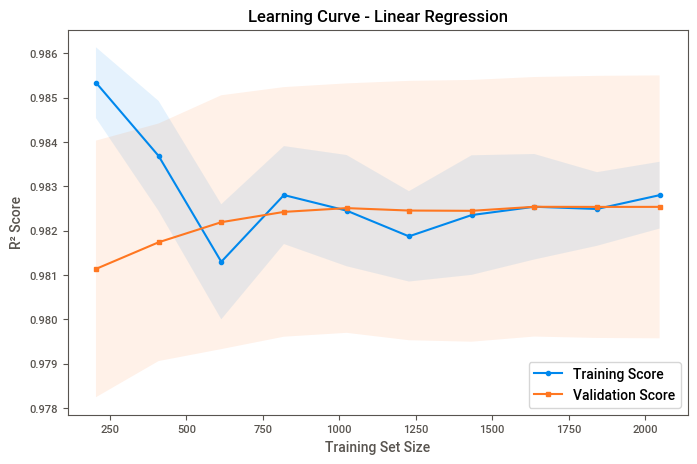

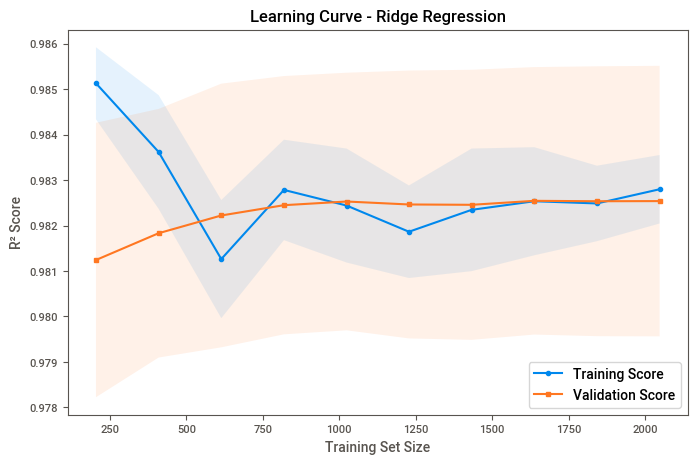

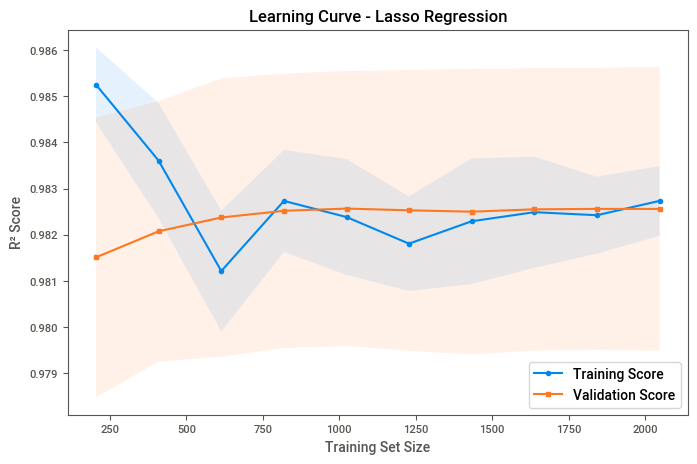

📊 Model Performance (with Cross-Validation):


,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²,CV R² Mean,CV R² Std
Model,,,,,,,,
Linear Regression,0.074458,0.062848,0.132431,0.102659,0.982772,0.988604,0.982610,0.005070
Ridge Regression,0.074433,0.062781,0.132439,0.102690,0.982770,0.988597,0.982611,0.005068
Lasso Regression,0.074742,0.063524,0.132691,0.102647,0.982704,0.988607,0.982624,0.005068



🏆 Best Performing Model: Lasso Regression (Cross-Validation R² = 0.9826)


In [9]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Load the preprocessed datasets
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")["y_train"]
y_test = pd.read_csv("y_test.csv")["y_test"]

# ✅ Define function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, cv_folds=5):
    """Trains, evaluates, and cross-validates a model"""
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Train the model
    model.fit(X_train, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics = {
        "Model": model_name,
        "Train MAE": mean_absolute_error(y_train, y_pred_train),
        "Test MAE": mean_absolute_error(y_test, y_pred_test),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Train R²": r2_score(y_train, y_pred_train),
        "Test R²": r2_score(y_test, y_pred_test),
        "CV R² Mean": np.mean(cv_scores),
        "CV R² Std": np.std(cv_scores)
    }
    
    return model, metrics

# ✅ Hyperparameter Tuning with GridSearchCV
def tune_model(model, param_grid, X_train, y_train):
    """Tunes hyperparameters using GridSearchCV"""
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="r2", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# ==============================
# 1️⃣ Hyperparameter Tuning
# ==============================
ridge_params = {"alpha": [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_params = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]}

ridge_model = tune_model(Ridge(), ridge_params, X_train, y_train)
lasso_model = tune_model(Lasso(), lasso_params, X_train, y_train)

# ✅ Train & Evaluate Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_model
}

results = []
trained_models = {}

# Create folder to store trained models & plots
output_folder = "trained_models"
os.makedirs(output_folder, exist_ok=True)

for name, model in models.items():
    trained_model, metrics = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    trained_models[name] = trained_model
    results.append(metrics)
    
    # ✅ Save trained model
    model_file_path = os.path.join(output_folder, f"{name.replace(' ', '_').lower()}_model.pkl")
    joblib.dump(trained_model, model_file_path)
    
    # ✅ Plot learning curves
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # Compute mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # ✅ Plot Learning Curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training Score", marker="o")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, test_mean, label="Validation Score", marker="s")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.title(f"Learning Curve - {name}")
    plt.legend()
    
    # ✅ Save Plot
    plot_path = os.path.join(output_folder, f"{name.replace(' ', '_').lower()}_learning_curve.png")
    plt.savefig(plot_path)
    plt.show()

# ✅ Convert results into a DataFrame
results_df = pd.DataFrame(results).set_index("Model")

# ✅ Display Results
print("📊 Model Performance (with Cross-Validation):")
display(results_df)

# ✅ Identify Best Model Based on Cross-Validation R² Score
best_model_name = results_df["CV R² Mean"].idxmax()
best_model_score = results_df.loc[best_model_name, "CV R² Mean"]

print(f"\n🏆 Best Performing Model: {best_model_name} (Cross-Validation R² = {best_model_score:.4f})")


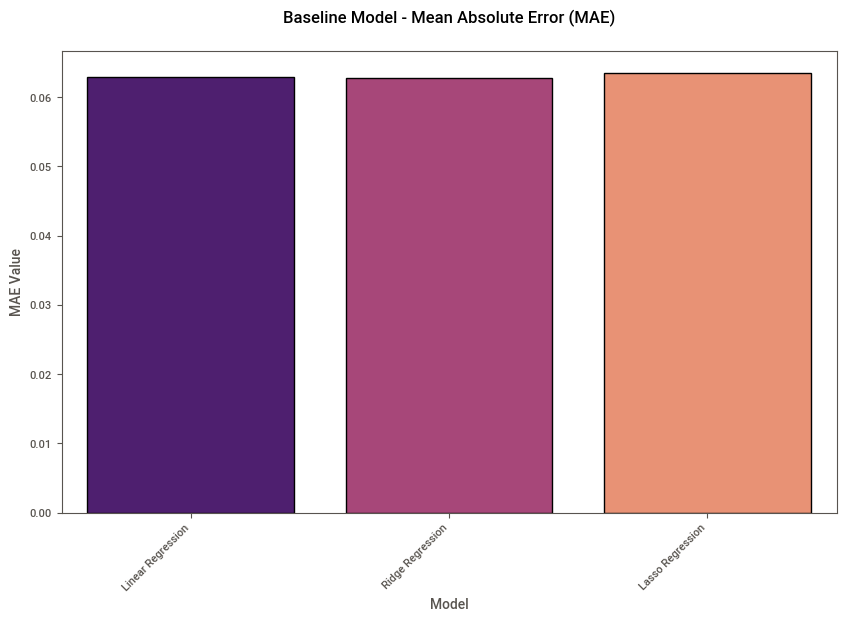

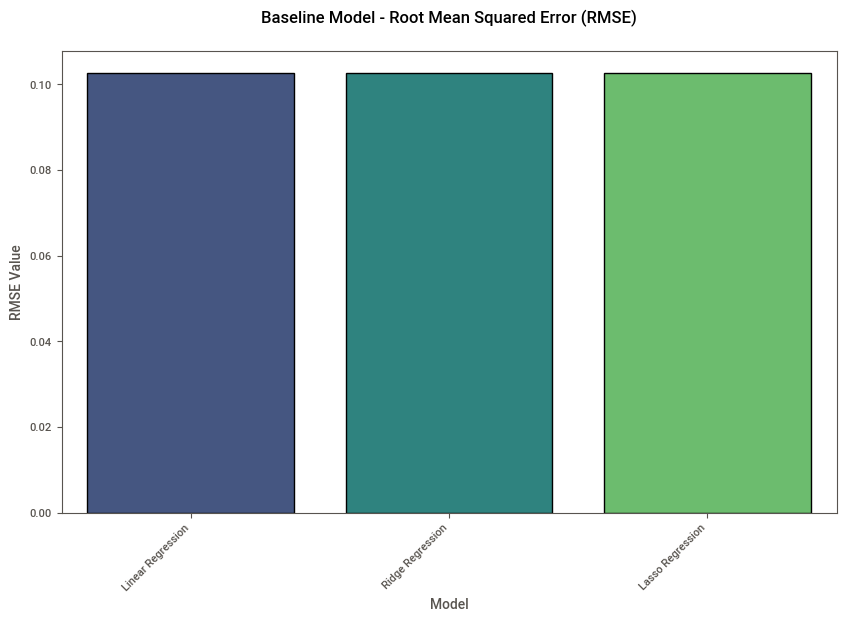

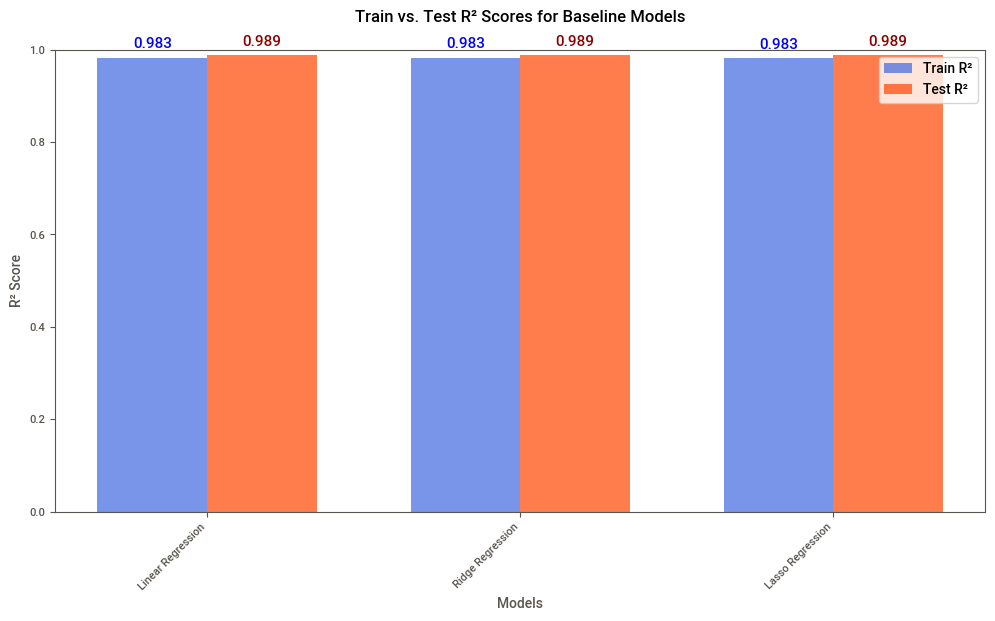

📊 Baseline Model MAE plot saved at: trained_models/baseline_model_mae.png
📊 Baseline Model RMSE plot saved at: trained_models/baseline_model_rmse.png
📈 Baseline Model R² Score plot saved at: trained_models/baseline_model_r2_scores.png

🏆 Best Performing Model: Lasso Regression (Test R² = 0.9886)


In [10]:
# ✅ Define file paths for plots
baseline_mae_path = os.path.join(output_folder, "baseline_model_mae.png")
baseline_rmse_path = os.path.join(output_folder, "baseline_model_rmse.png")
baseline_r2_score_path = os.path.join(output_folder, "baseline_model_r2_scores.png")

# 📊 **Baseline Model MAE Comparison**
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df["Test MAE"], palette="magma", edgecolor="black")
plt.title("Baseline Model - Mean Absolute Error (MAE)", pad=20)
plt.ylabel("MAE Value")
plt.xticks(rotation=45, ha="right")

# ✅ Log scale for better visibility (optional)
# plt.yscale("log")

plt.savefig(baseline_mae_path, dpi=300)
plt.show()

# 📊 **Baseline Model RMSE Comparison**
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df["Test RMSE"], palette="viridis", edgecolor="black")
plt.title("Baseline Model - Root Mean Squared Error (RMSE)", pad=20)
plt.ylabel("RMSE Value")
plt.xticks(rotation=45, ha="right")

# ✅ Log scale for better visibility (optional)
# plt.yscale("log")

plt.savefig(baseline_rmse_path, dpi=300)
plt.show()

# 📈 **R² Scores of Baseline Models (Train vs. Test)**
plt.figure(figsize=(12, 6))
bar_width = 0.35  # Width of bars
indices = range(len(results_df.index))

plt.bar(indices, results_df["Train R²"], bar_width, label="Train R²", color="royalblue", alpha=0.7)
plt.bar([i + bar_width for i in indices], results_df["Test R²"], bar_width, label="Test R²", color="orangered", alpha=0.7)

plt.xlabel("Models")
plt.ylabel("R² Score")
plt.title("Train vs. Test R² Scores for Baseline Models", pad=20)
plt.xticks([i + bar_width / 2 for i in indices], results_df.index, rotation=45, ha="right")
plt.ylim(0, 1)
plt.legend()

# ✅ Add labels to bars
for i, (train_r2, test_r2) in enumerate(zip(results_df["Train R²"], results_df["Test R²"])):
    plt.text(i, train_r2 + 0.02, f"{train_r2:.3f}", ha="center", fontsize=11, fontweight="bold", color="blue")
    plt.text(i + bar_width, test_r2 + 0.02, f"{test_r2:.3f}", ha="center", fontsize=11, fontweight="bold", color="darkred")

plt.savefig(baseline_r2_score_path, dpi=300)
plt.show()

# ✅ Print confirmation
print(f"📊 Baseline Model MAE plot saved at: {baseline_mae_path}")
print(f"📊 Baseline Model RMSE plot saved at: {baseline_rmse_path}")
print(f"📈 Baseline Model R² Score plot saved at: {baseline_r2_score_path}")

# ✅ Identify Best Model Based on Test R² Score
best_model_name = results_df["Test R²"].idxmax()
best_model_score = results_df.loc[best_model_name, "Test R²"]

print(f"\n🏆 Best Performing Model: {best_model_name} (Test R² = {best_model_score:.4f})")


📊 Elastic Net Model Performance:


,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
Model,,,,,,
Elastic Net,0.074896,0.064114,0.134818,0.104857,0.982145,0.988111


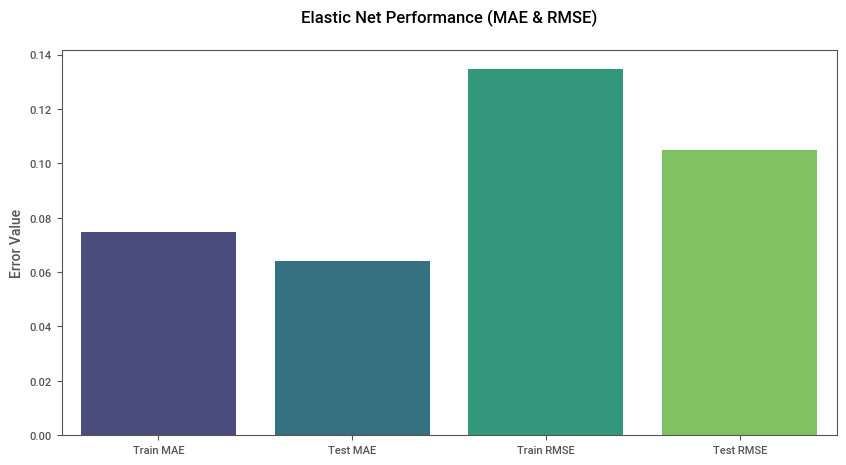

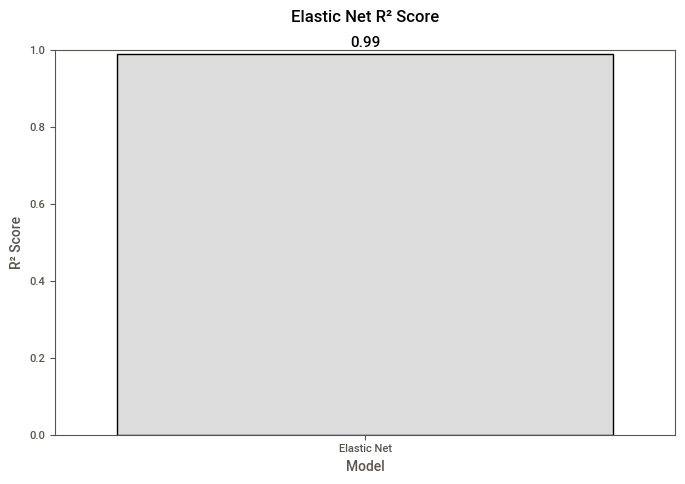

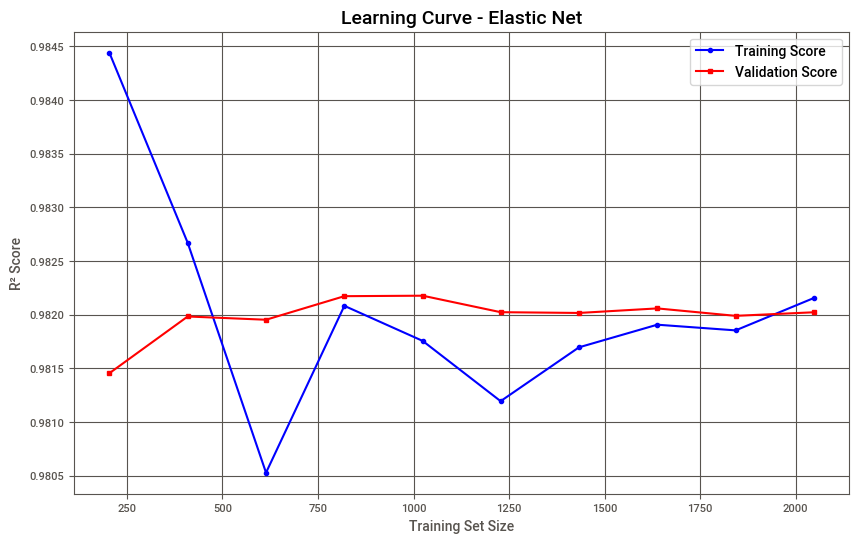

📈 Learning curve plot saved at: plots/elastic_net_learning_curve.png
📊 Elastic Net MAE & RMSE plot saved at: plots/elastic_net_mae_rmse.png
📈 Elastic Net R² Score plot saved at: plots/elastic_net_r2_scores.png
💾 Elastic Net model saved at: trained_models/elastic_net_model.pkl


In [11]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# ✅ Load the preprocessed datasets
# X_train = pd.read_csv("X_train.csv")
# X_test = pd.read_csv("X_test.csv")
# y_train = pd.read_csv("y_train.csv")["y_train"]
# y_test = pd.read_csv("y_test.csv")["y_test"]

# ✅ Function to train & evaluate Elastic Net
def evaluate_elastic_net(alpha, l1_ratio, X_train, X_test, y_train, y_test):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics = {
        "Model": "Elastic Net",
        "Train MAE": mean_absolute_error(y_train, y_pred_train),
        "Test MAE": mean_absolute_error(y_test, y_pred_test),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Train R²": r2_score(y_train, y_pred_train),
        "Test R²": r2_score(y_test, y_pred_test)
    }
    
    return model, metrics

# ✅ Function to plot the learning curve
def plot_learning_curve(model, X_train, y_train, model_name):
    """Generates and saves a learning curve for the model."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring="r2",
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, marker='o', color='blue', label="Training Score")
    plt.plot(train_sizes, val_mean, marker='s', color='red', label="Validation Score")
    
    plt.title(f"Learning Curve - {model_name}", fontsize=14)
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid(True)
    
    # ✅ Save the learning curve plot
    learning_curve_path = os.path.join(output_folder, f"{model_name.replace(' ', '_').lower()}_learning_curve.png")
    plt.savefig(learning_curve_path, dpi=300)
    plt.show()
    
    print(f"📈 Learning curve plot saved at: {learning_curve_path}")

# ✅ Train & Evaluate Elastic Net Regression
alpha = 0.01  # Regularization strength
l1_ratio = 0.5  # Balance between L1 (Lasso) & L2 (Ridge)

elastic_net_model, elastic_net_metrics = evaluate_elastic_net(alpha, l1_ratio, X_train, X_test, y_train, y_test)

# ✅ Create folders if not exists
model_folder = "trained_models"
output_folder = "plots"
os.makedirs(model_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# ✅ Save Elastic Net model
elastic_net_model_path = os.path.join(model_folder, "elastic_net_model.pkl")
joblib.dump(elastic_net_model, elastic_net_model_path)

# ✅ Convert results into a DataFrame
elastic_net_results_df = pd.DataFrame([elastic_net_metrics]).set_index("Model")

# ✅ Display Results
print("📊 Elastic Net Model Performance:")
display(elastic_net_results_df)

# ✅ Define file paths for plots
elastic_net_mae_rmse_path = os.path.join(output_folder, "elastic_net_mae_rmse.png")
elastic_net_r2_score_path = os.path.join(output_folder, "elastic_net_r2_scores.png")

# 📊 **Elastic Net Performance (MAE & RMSE)**
plt.figure(figsize=(10, 5))
sns.barplot(data=elastic_net_results_df.drop(columns=["Train R²", "Test R²"]), palette="viridis")
plt.title("Elastic Net Performance (MAE & RMSE)", pad=20)
plt.ylabel("Error Value")
plt.savefig(elastic_net_mae_rmse_path, dpi=300)
plt.show()

# 📈 **Elastic Net R² Score**
plt.figure(figsize=(8, 5))
sns.barplot(x=elastic_net_results_df.index, y=elastic_net_results_df["Test R²"], palette="coolwarm", edgecolor="black")
plt.title("Elastic Net R² Score", pad=20)
plt.ylim(0, 1)

# ✅ Add data labels
for index, value in enumerate(elastic_net_results_df["Test R²"]):
    plt.text(index, value + 0.02, f"{value:.2f}", ha="center", fontsize=11, fontweight="bold")

plt.ylabel("R² Score")
plt.savefig(elastic_net_r2_score_path, dpi=300)
plt.show()

# ✅ Plot learning curve for Elastic Net
plot_learning_curve(elastic_net_model, X_train, y_train, "Elastic Net")

# ✅ Print confirmation
print(f"📊 Elastic Net MAE & RMSE plot saved at: {elastic_net_mae_rmse_path}")
print(f"📈 Elastic Net R² Score plot saved at: {elastic_net_r2_score_path}")
print(f"💾 Elastic Net model saved at: {elastic_net_model_path}")


# 📌 Step 3: Train & Evaluate Bagging Models (Random Forest, Extra Trees, etc.)
### 📢 What We Will Do?
#### ✅ Train & evaluate bagging-based models like Random Forest & Extra Trees.
#### ✅ Compare their performance using MAE, RMSE, and R² Score.
#### ✅ Save the trained models for later use.

🔍 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Random Forest Score: 0.9602
✅ Best Random Forest Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15}
⏳ Tuning Time: 2.75 seconds


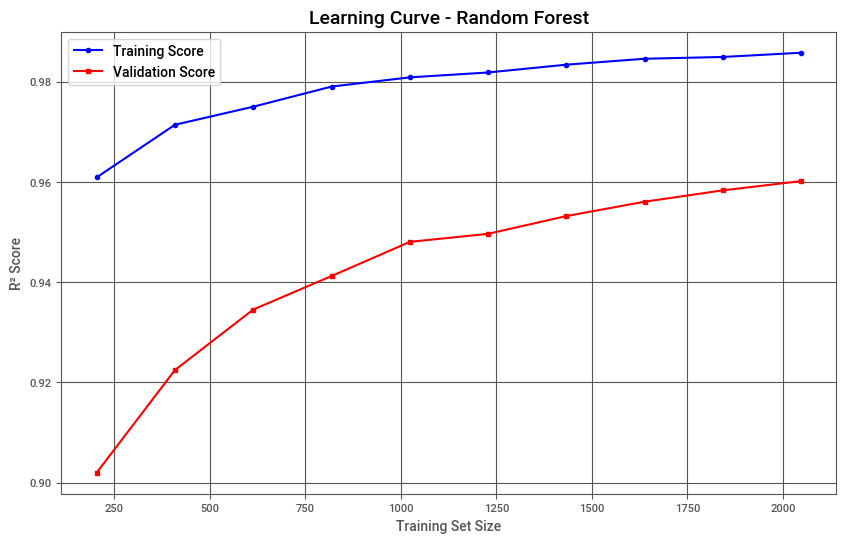

📈 Learning curve plot saved at: plots/random_forest_learning_curve.png
🔍 Tuning Extra Trees...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Extra Trees Score: 0.9671
✅ Best Extra Trees Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15}
⏳ Tuning Time: 1.38 seconds


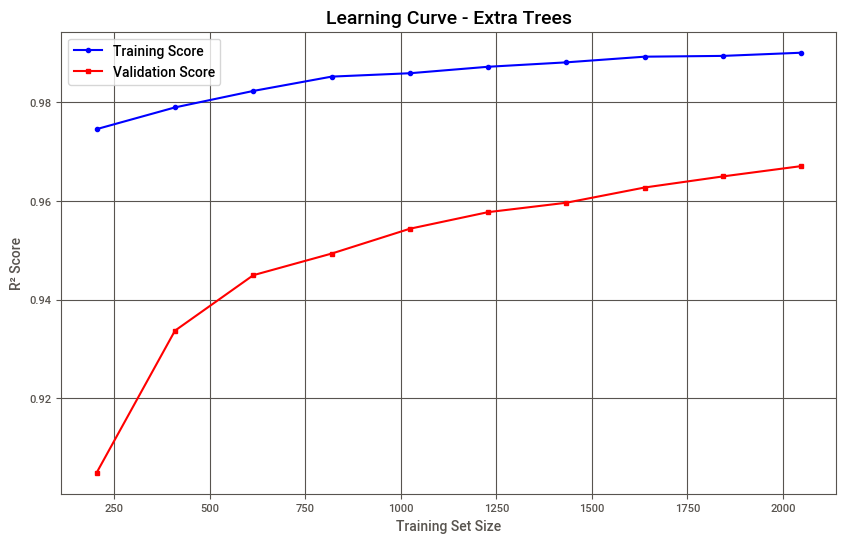

📈 Learning curve plot saved at: plots/extra_trees_learning_curve.png
📊 Bagging Model Performance:


,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²,CV R² Mean,CV R² Std
Model,,,,,,,,
Random Forest,0.080586,0.126676,0.114849,0.163246,0.987043,0.971184,0.959193,0.003608
Extra Trees,0.066679,0.108600,0.096194,0.145559,0.990910,0.977090,0.965938,0.002751


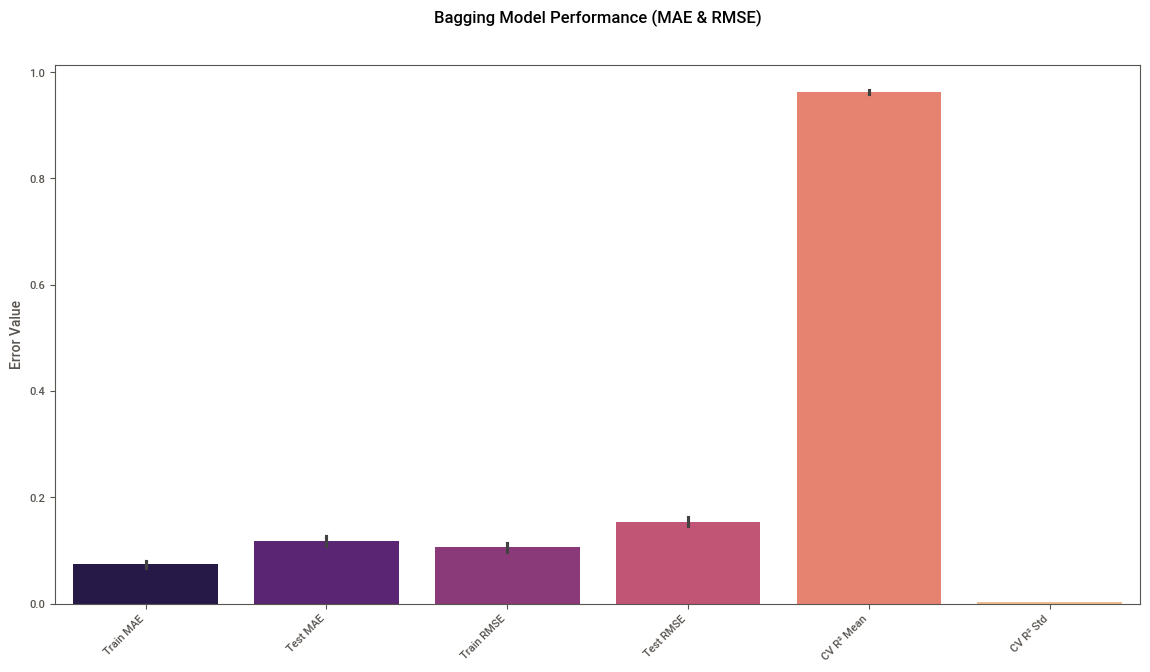

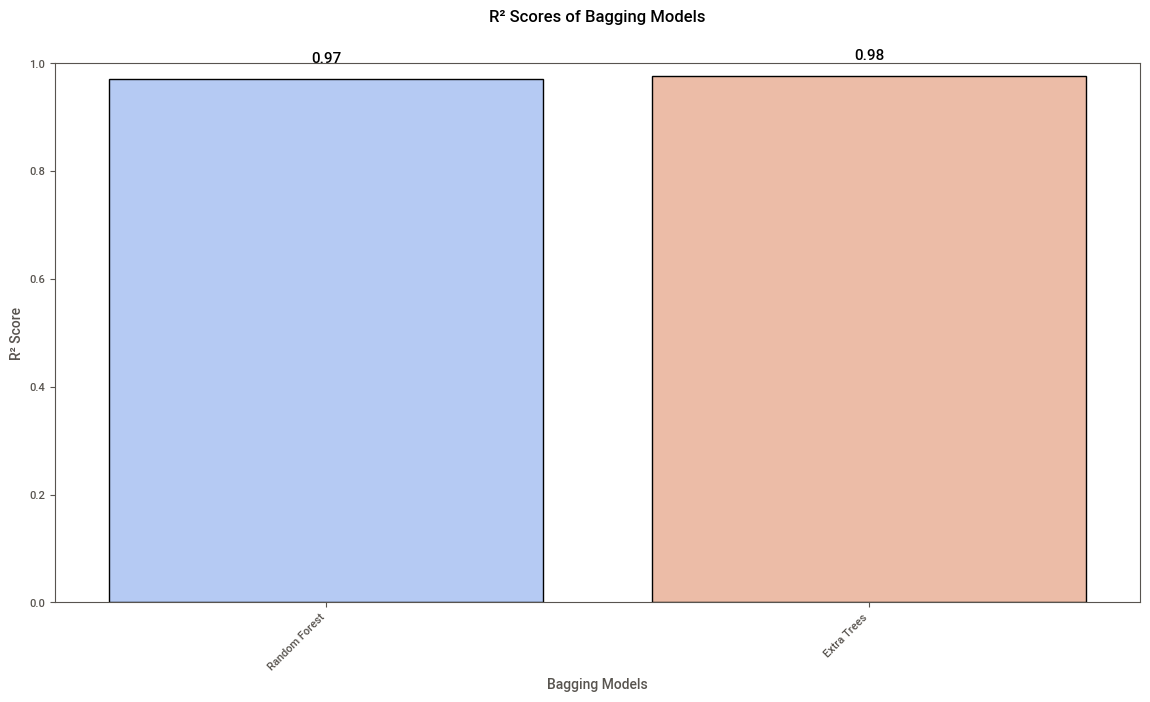

📊 Bagging Model MAE & RMSE plot saved at: plots/bagging_model_mae_rmse.png
📈 Bagging Model R² Score plot saved at: plots/bagging_model_r2_scores.png

🏆 Best Performing Model: Extra Trees (Test R² = 0.9771)


In [12]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from scipy.stats import randint
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ✅ Define Initial Bagging Models
bagging_models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42)
}

# ✅ Hyperparameter Grid
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [5, 10, 15, 20],
    "min_samples_leaf": [2, 5, 8, 10],
    "max_features": ["sqrt", "log2", None]
}

# ✅ Function to Tune Models
def tune_model(model, model_name, X_train, y_train):
    print(f"🔍 Tuning {model_name}...")
    start_time = time.time()

    search = RandomizedSearchCV(
        model, param_distributions=param_grid, 
        n_iter=20, cv=5, scoring="r2", 
        n_jobs=-1, verbose=2, random_state=42
    )

    search.fit(X_train, y_train)

    best_params = search.best_params_
    best_score = search.best_score_

    print(f"✅ Best {model_name} Score: {best_score:.4f}")
    print(f"✅ Best {model_name} Params: {best_params}")
    print(f"⏳ Tuning Time: {time.time() - start_time:.2f} seconds")

    return search.best_estimator_

# ✅ Train & Evaluate Bagging Models
bagging_results = []
bagging_trained_models = {}

# Define model_folder and output_folder
model_folder = "trained_models"
output_folder = "plots"

# Create necessary directories
os.makedirs(model_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# ✅ Function to Generate Learning Curve
def plot_learning_curve(model, X_train, y_train, model_name):
    """Generates and saves a learning curve for the model."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring="r2",
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, marker='o', color='blue', label="Training Score")
    plt.plot(train_sizes, val_mean, marker='s', color='red', label="Validation Score")
    
    plt.title(f"Learning Curve - {model_name}", fontsize=14)
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid(True)
    
    # ✅ Save the learning curve plot
    learning_curve_path = os.path.join(output_folder, f"{model_name.replace(' ', '_').lower()}_learning_curve.png")
    plt.savefig(learning_curve_path, dpi=300)
    plt.show()
    
    print(f"📈 Learning curve plot saved at: {learning_curve_path}")

# ✅ Train, Tune, Evaluate & Generate Learning Curves
for name, model in bagging_models.items():
    # ✅ Tune the model
    best_model = tune_model(model, name, X_train, y_train)

    # ✅ Evaluate the best model
    trained_model, metrics = evaluate_model(best_model, X_train, X_test, y_train, y_test, name)
    bagging_trained_models[name] = trained_model
    bagging_results.append(metrics)
    
    # ✅ Save the trained model
    model_file_path = os.path.join(model_folder, f"{name.replace(' ', '_').lower()}_model.pkl")
    joblib.dump(trained_model, model_file_path)

    # ✅ Generate Learning Curve
    plot_learning_curve(trained_model, X_train, y_train, name)

# ✅ Convert results into a DataFrame
bagging_results_df = pd.DataFrame(bagging_results).set_index("Model")

# ✅ Save the trained bagging models
joblib.dump(bagging_trained_models, os.path.join(model_folder, "bagging_models.pkl"))

# ✅ Display Results
print("📊 Bagging Model Performance:")
display(bagging_results_df)

# ✅ Define file paths for plots
bagging_mae_rmse_path = os.path.join(output_folder, "bagging_model_mae_rmse.png")
bagging_r2_score_path = os.path.join(output_folder, "bagging_model_r2_scores.png")

# 📊 **Bagging Model Performance (MAE & RMSE)**
plt.figure(figsize=(14, 7))
sns.barplot(data=bagging_results_df.drop(columns=["Train R²", "Test R²"]), palette="magma")
plt.title("Bagging Model Performance (MAE & RMSE)", pad=30)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Error Value")
plt.savefig(bagging_mae_rmse_path, dpi=300)
plt.show()

# 📈 **R² Scores of Bagging Models**
plt.figure(figsize=(14, 7))
sns.barplot(x=bagging_results_df.index, y=bagging_results_df["Test R²"], palette="coolwarm", edgecolor="black")
plt.title("R² Scores of Bagging Models", pad=30)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# ✅ Add data labels on top of bars
for index, value in enumerate(bagging_results_df["Test R²"]):
    plt.text(index, value + 0.03, f"{value:.2f}", ha="center", fontsize=11, fontweight="bold")

plt.ylabel("R² Score")
plt.xlabel("Bagging Models")
plt.savefig(bagging_r2_score_path, dpi=300)
plt.show()

# ✅ Print confirmation
print(f"📊 Bagging Model MAE & RMSE plot saved at: {bagging_mae_rmse_path}")
print(f"📈 Bagging Model R² Score plot saved at: {bagging_r2_score_path}")

# ✅ Identify Best Model Based on R² Score
best_model_name = bagging_results_df["Test R²"].idxmax()
best_model_score = bagging_results_df.loc[best_model_name, "Test R²"]

print(f"\n🏆 Best Performing Model: {best_model_name} (Test R² = {best_model_score:.4f})")


# 📊 Step 4: Compare Bagging Models vs. Baseline Models
### 📢 What We Will Do?
#### ✅ Compare the performance of bagging models (Random Forest, Extra Trees) with baseline models (Linear Regression, Decision Tree, etc.).
#### ✅ Use MAE, RMSE, and R² Score to evaluate their effectiveness.
#### ✅ Visualize the results with bar plots.

📊 Baseline vs. Bagging Model Performance:


,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²,CV R² Mean,CV R² Std
Model,,,,,,,,
Linear Regression,0.074458,0.062848,0.132431,0.102659,0.982772,0.988604,0.982610,0.005070
Ridge Regression,0.074433,0.062781,0.132439,0.102690,0.982770,0.988597,0.982611,0.005068
Lasso Regression,0.074742,0.063524,0.132691,0.102647,0.982704,0.988607,0.982624,0.005068
Random Forest,0.080586,0.126676,0.114849,0.163246,0.987043,0.971184,0.959193,0.003608
Extra Trees,0.066679,0.108600,0.096194,0.145559,0.990910,0.977090,0.965938,0.002751


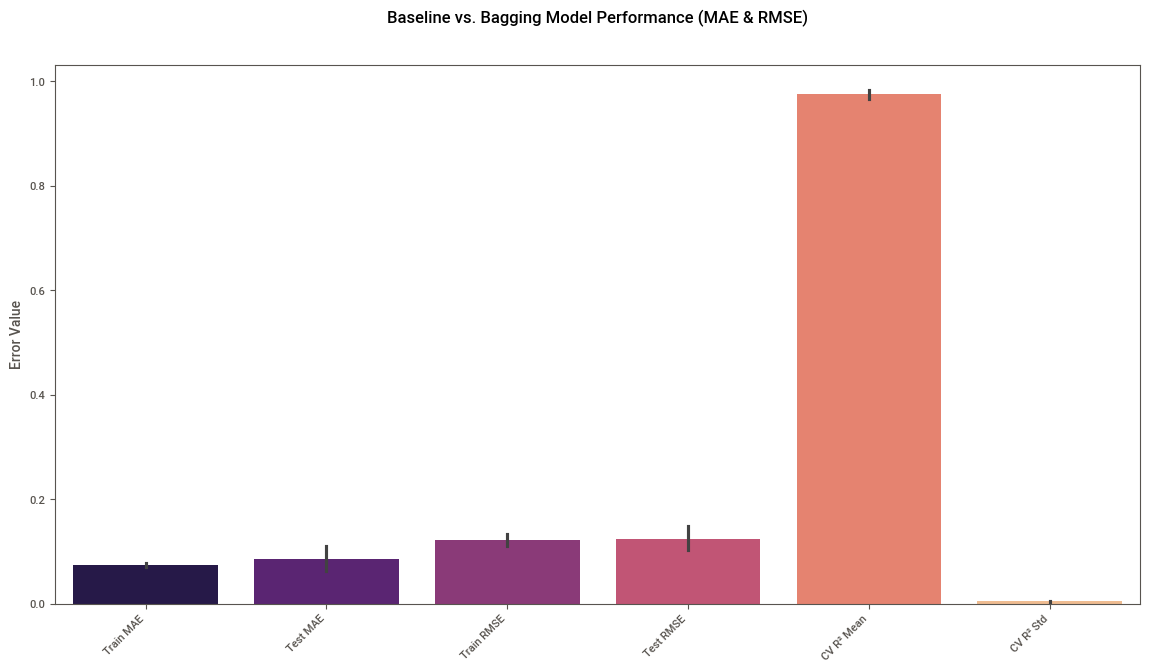

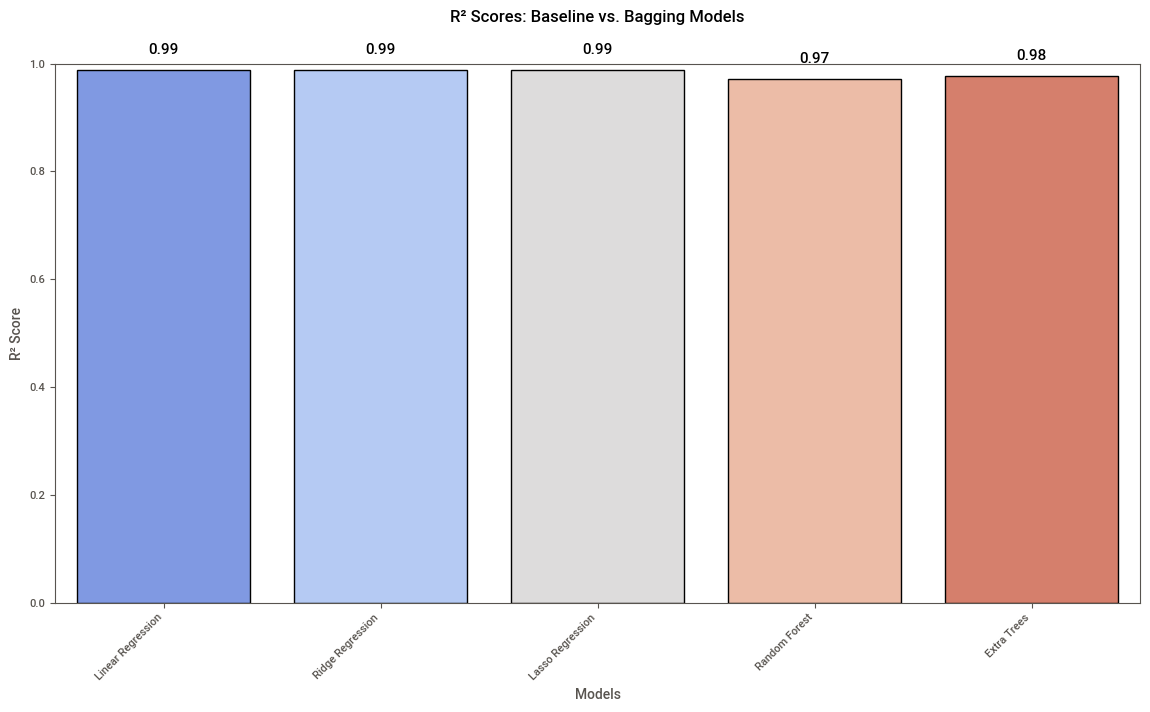

📊 Baseline vs. Bagging MAE & RMSE plot saved at: plots/bagging_mae_rmse_comparison.png
📈 Baseline vs. Bagging R² Score plot saved at: plots/bagging_r2_comparison.png

🏆 Best Performing Model: Lasso Regression (Test R² = 0.9886)


In [13]:
# ==================================================
# 📌 Step 4: Compare Bagging Models vs. Baseline Models
# ==================================================

# ✅ Load previous results
baseline_results_df = pd.DataFrame(results).set_index("Model")  # Load saved baseline results
bagging_results_df = pd.DataFrame(bagging_results).set_index("Model")  # Bagging model results

# ✅ Combine Results for Comparison
comparison_df = pd.concat([baseline_results_df, bagging_results_df])

# ✅ Display Comparison Table
print("📊 Baseline vs. Bagging Model Performance:")
display(comparison_df)

# ✅ Define file paths
bagging_mae_rmse_path = os.path.join(output_folder, "bagging_mae_rmse_comparison.png")
bagging_r2_score_path = os.path.join(output_folder, "bagging_r2_comparison.png")

# 📊 **Baseline vs. Bagging Model Performance (MAE & RMSE)**
plt.figure(figsize=(14, 7))
sns.barplot(data=comparison_df.drop(columns=["Train R²", "Test R²"]), palette="magma")
plt.title("Baseline vs. Bagging Model Performance (MAE & RMSE)", pad=30)
plt.xticks(rotation=45, ha="right")  # Better readability
plt.ylabel("Error Value")
plt.savefig(bagging_mae_rmse_path, dpi=300)  # No tight cropping
plt.show()

# 📈 **Baseline vs. Bagging Models R² Score Comparison**
plt.figure(figsize=(14, 7))
sns.barplot(x=comparison_df.index, y=comparison_df["Test R²"], palette="coolwarm", edgecolor="black")
plt.title("R² Scores: Baseline vs. Bagging Models", pad=30)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")  # Improved spacing

# ✅ Add data labels on top of bars
for index, value in enumerate(comparison_df["Test R²"]):
    plt.text(index, value + 0.03, f"{value:.2f}", ha="center", fontsize=11, fontweight="bold")

plt.ylabel("R² Score")
plt.xlabel("Models")
plt.savefig(bagging_r2_score_path, dpi=300)  # No bbox_inches="tight"
plt.show()

# ✅ Print confirmation
print(f"📊 Baseline vs. Bagging MAE & RMSE plot saved at: {bagging_mae_rmse_path}")
print(f"📈 Baseline vs. Bagging R² Score plot saved at: {bagging_r2_score_path}")

# ✅ Identify Best Model Based on R² Score
best_model_name = comparison_df["Test R²"].idxmax()
best_model_score = comparison_df.loc[best_model_name, "Test R²"]

print(f"\n🏆 Best Performing Model: {best_model_name} (Test R² = {best_model_score:.4f})")

In [14]:
import pandas as pd
import numpy as np
import joblib
from preprocessing import process_grades, process_midterms  # Ensure this import is correct
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================
# 1️⃣ Load Required Files
# ==============================
print("🔄 Loading required files...")

try:
    models = {
        "model": joblib.load("trained_models/elastic_net_model.pkl"),
        "Random Forest": joblib.load("trained_models/random_forest_model.pkl"),
        "Ridge Regression": joblib.load("trained_models/ridge_regression_model.pkl"),
        "Lasso Regression": joblib.load("trained_models/lasso_regression_model.pkl")
    }
    scaler = joblib.load("scaler.pkl")
    target_scaler = joblib.load("target_scaler.pkl")
    selected_features = joblib.load("selected_features.pkl")
    encoding_dict = joblib.load("encoding_dict.pkl")

    print("✅ Files loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ ERROR: File not found: {e}")
    exit()

# ==============================
# 2️⃣ Load & Preprocess Unseen Data
# ==============================
print("🔄 Loading unseen data...")

try:
    unseen_data = pd.read_csv("predicted_semester_gpa.csv")
    if "Predicted Semester GPA" in unseen_data.columns:
        actual_gpa = unseen_data[["Predicted Semester GPA"]].copy()
    else:
        raise ValueError("❌ ERROR: 'Predicted Semester GPA' column is missing in unseen data!")
except FileNotFoundError:
    print("Error: predicted_semester_gpa.csv not found")
    exit()

drop_cols = {
    "Registration Number", "Specialization", "Branch", "Last Semester",
    "Predicted GPA (Linear Regression)", "Predicted GPA (Ridge Regression)", "Predicted GPA (Lasso Regression)",
}
unseen_data.drop(columns=drop_cols.intersection(unseen_data.columns), inplace=True)

# ==============================
# 📌 Compute Missing Features
# ==============================
print("🔄 Computing missing features...")

if "Grades (S, A, B, C, D, E, F, N)" in unseen_data.columns:
    unseen_data["Average Grade"], unseen_data["Grade Std Dev"] = zip(
        *unseen_data["Grades (S, A, B, C, D, E, F, N)"].apply(process_grades)
    )
    unseen_data.drop(columns=["Grades (S, A, B, C, D, E, F, N)"], inplace=True)
else:
    print("Error: 'Grades (S, A, B, C, D, E, F, N)' column not found")
    exit()

if "Midterm Scores (out of 50)" in unseen_data.columns:
    unseen_data["Average Midterm Score"], unseen_data["Weighted Midterm Score"] = zip(
        *unseen_data.apply(
            lambda row: process_midterms(row["Midterm Scores (out of 50)"], actual_gpa.iloc[row.name, 0]), axis=1
        )
    )
    unseen_data.drop(columns=["Midterm Scores (out of 50)"], inplace=True)
else:
    print("Error: 'Midterm Scores (out of 50)' column not found")
    exit()

print("✅ Missing features computed successfully!")

unseen_data.drop(columns=["Predicted Semester GPA"], inplace=True)

# ==============================
# 3️⃣ Ensure Correct Features (Hard Matching)
# ==============================
print("🔄 Ensuring unseen data has the correct features...")

expected_features = [str(col).strip() for col in selected_features]
unseen_data.columns = [str(col).strip() for col in unseen_data.columns]

missing_features = [col for col in expected_features if col not in unseen_data.columns]
extra_features = [col for col in unseen_data.columns if col not in expected_features]

for col in missing_features:
    print(f"⚠️ WARNING: Missing feature '{col}' detected. Adding as NaN...")
    unseen_data[col] = np.nan

if extra_features:
    print(f"⚠️ WARNING: Extra features detected and will be removed: {extra_features}")
    unseen_data.drop(columns=extra_features, inplace=True)

unseen_data = unseen_data[expected_features]

# Apply encoding to categorical columns
for col, mapping in encoding_dict.items():
    if col in unseen_data.columns:
        unseen_data[col] = unseen_data[col].map(mapping).fillna(-1)

unseen_data = unseen_data.astype(np.float64)

print("✅ Unseen data preprocessing completed successfully!")

# ==============================
# 4️⃣ Optimize Ridge & Lasso with GridSearchCV
# ==============================
print("🔄 Performing hyperparameter tuning for Ridge & Lasso...")

ridge_params = {"alpha": [0.1, 1, 10, 50, 100]}
lasso_params = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

# Scale features before fitting
scaled_unseen_data = scaler.transform(unseen_data)

# Apply same scaling to targets
scaled_target = target_scaler.transform(actual_gpa)

ridge_cv = GridSearchCV(Ridge(), ridge_params, cv=5, scoring="neg_mean_squared_error")
lasso_cv = GridSearchCV(Lasso(), lasso_params, cv=5, scoring="neg_mean_squared_error")

ridge_cv.fit(scaled_unseen_data, scaled_target.ravel())
lasso_cv.fit(scaled_unseen_data, scaled_target.ravel())

best_ridge = ridge_cv.best_estimator_
best_lasso = lasso_cv.best_estimator_

print(f"✅ Best Ridge Alpha: {ridge_cv.best_params_['alpha']}")
print(f"✅ Best Lasso Alpha: {lasso_cv.best_params_['alpha']}")

models["Ridge Regression"] = best_ridge
models["Lasso Regression"] = best_lasso

# ==============================
# 5️⃣ Make Predictions with Each Model
# ==============================
print("🔄 Making predictions...")

# Reorder and scale features
unseen_data = unseen_data[selected_features]
scaled_unseen_data = scaler.transform(unseen_data)

predictions = {}
for model_name, model in models.items():
    print(f"🔹 Predicting with {model_name}...")
    try:
        predictions[model_name] = model.predict(scaled_unseen_data).flatten()
    except ValueError as e:
        print(f"ValueError during prediction with {model_name}: {e}")
        print(unseen_data.isna().sum())
        raise  # Stop if there's an issue

# Inverse transform predictions
for model_name, pred in predictions.items():
    predictions[model_name] = target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

# Save predictions
for model_name, pred in predictions.items():
    unseen_data[f"Predicted GPA ({model_name})"] = pred

unseen_data.to_csv("predictions.csv", index=False)
print("✅ Predictions saved successfully as 'predictions.csv'! 🎯")

# ==============================
# 6️⃣ Evaluate Model Performance
# ==============================
print("\n📊 **Model Performance Metrics**")

evaluation_results = {}

for model_name, pred in predictions.items():
    y_pred = pd.Series(pred).reset_index(drop=True)

    mae = mean_absolute_error(actual_gpa, y_pred)
    mse = mean_squared_error(actual_gpa, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_gpa, y_pred)

    evaluation_results[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R² Score": r2}

    print(f"\n📌 **{model_name}**")
    print(f"✅ MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df.to_csv("model_evaluation.csv")

print("\n✅ Model evaluation saved as 'model_evaluation.csv'! 🎯")

# Show a preview of actual vs predicted
print("\n🔹 First Few Predictions vs Actual:")
comparison_df = pd.DataFrame({"Actual GPA": actual_gpa.values.flatten()})
for model_name, pred in predictions.items():
    comparison_df[f"Predicted GPA ({model_name})"] = pred

print(comparison_df.head())


🔄 Loading required files...
✅ Files loaded successfully!
🔄 Loading unseen data...
🔄 Computing missing features...
✅ Missing features computed successfully!
🔄 Ensuring unseen data has the correct features...
✅ Unseen data preprocessing completed successfully!
🔄 Performing hyperparameter tuning for Ridge & Lasso...
✅ Best Ridge Alpha: 0.1
✅ Best Lasso Alpha: 0.001
🔄 Making predictions...
🔹 Predicting with model...
🔹 Predicting with Random Forest...
🔹 Predicting with Ridge Regression...
🔹 Predicting with Lasso Regression...
✅ Predictions saved successfully as 'predictions.csv'! 🎯

📊 **Model Performance Metrics**

📌 **model**
✅ MAE: 0.5102, MSE: 0.3973, RMSE: 0.6303, R²: 0.6123

📌 **Random Forest**
✅ MAE: 0.6403, MSE: 0.6245, RMSE: 0.7903, R²: 0.3906

📌 **Ridge Regression**
✅ MAE: 0.0143, MSE: 0.0004, RMSE: 0.0188, R²: 0.9997

📌 **Lasso Regression**
✅ MAE: 0.0151, MSE: 0.0004, RMSE: 0.0195, R²: 0.9996

✅ Model evaluation saved as 'model_evaluation.csv'! 🎯

🔹 First Few Predictions vs Actual

In [15]:
# ==============================
# 7️⃣ Create DataFrame for Visualization
# ==============================
df_preds = comparison_df.copy()  # This is the full prediction vs actual DataFrame

# Optional: Save for future visualization use
df_preds.to_csv("gpa_predictions_vs_actual.csv", index=False)
print("\n✅ DataFrame 'df_preds' created and saved as 'gpa_predictions_vs_actual.csv'!")



✅ DataFrame 'df_preds' created and saved as 'gpa_predictions_vs_actual.csv'!


# Model Comparison: Performance Metrics

Compare all models (Stacked/Custom, Random Forest, Ridge, Lasso) using a bar chart for:

- **MAE**
- **RMSE**
- **R²**

📊 Gives a quick snapshot of which model dominates where.


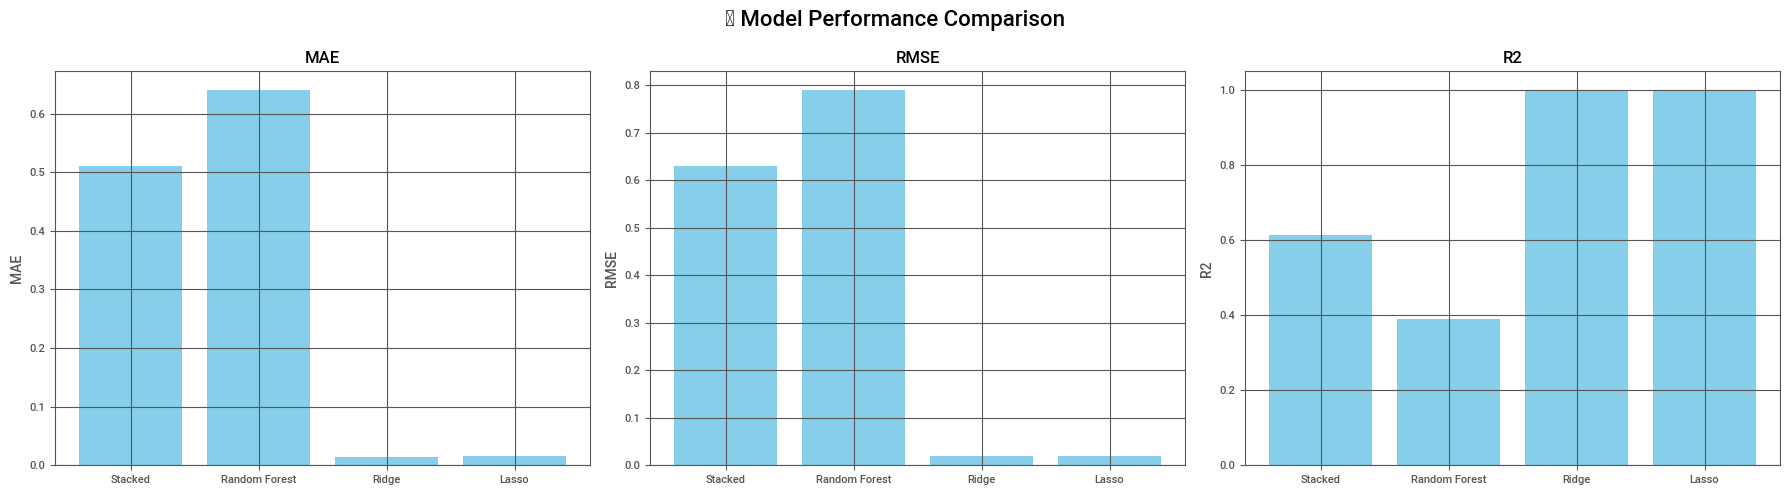

In [16]:
import matplotlib.pyplot as plt

metrics = {
    'Model': ['Stacked', 'Random Forest', 'Ridge', 'Lasso'],
    'MAE': [0.5102, 0.6403, 0.0143, 0.0151],
    'RMSE': [0.6303, 0.7903, 0.0188, 0.0195],
    'R2': [0.6123, 0.3906, 0.9997, 0.9996]
}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['MAE', 'RMSE', 'R2']):
    axs[i].bar(metrics['Model'], metrics[metric], color='skyblue')
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

plt.suptitle('📊 Model Performance Comparison', fontsize=16)
plt.tight_layout()
plt.show()


# 🧪 2. Prediction vs Actual Plot

This shows how close the predicted GPAs are to actual ones.

- A straight line = model is perfect.
- The closer your points are to the line, the better.


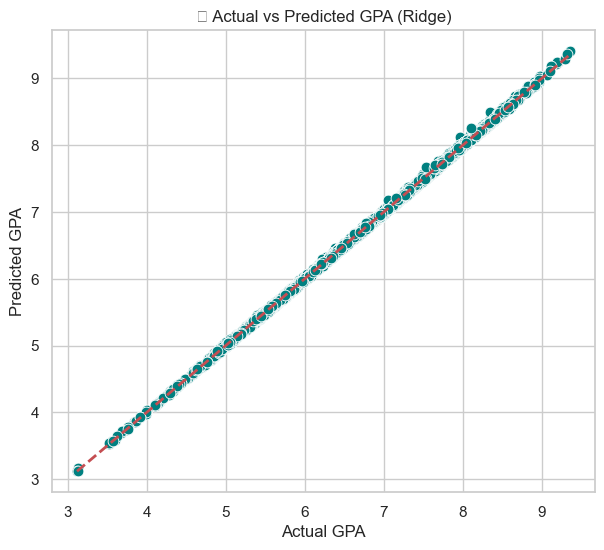

In [17]:
import seaborn as sns

# assuming df_preds has actual and predictions
sns.set(style="whitegrid")
plt.figure(figsize=(7, 6))
sns.scatterplot(x='Actual GPA', y='Predicted GPA (Ridge Regression)', data=df_preds, color='teal', s=60)
plt.plot([df_preds['Actual GPA'].min(), df_preds['Actual GPA'].max()],
         [df_preds['Actual GPA'].min(), df_preds['Actual GPA'].max()], 'r--', lw=2)
plt.title("📈 Actual vs Predicted GPA (Ridge)")
plt.xlabel("Actual GPA")
plt.ylabel("Predicted GPA")
plt.show()


# Residual Plot (Ridge/Lasso)

Shows errors. Residuals should be randomly scattered around zero if the model is unbiased.


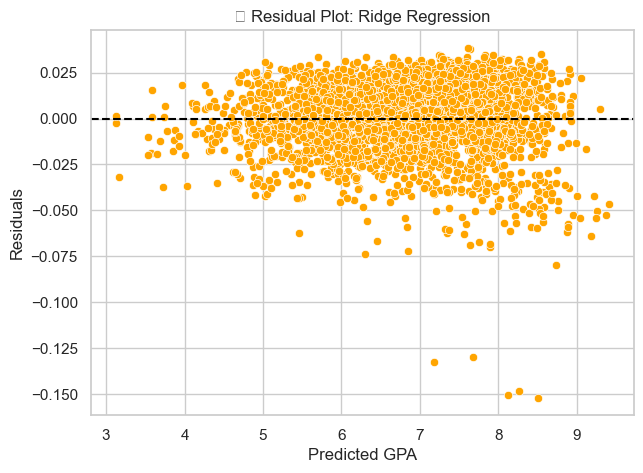

In [18]:
df_preds['Residuals_Ridge'] = df_preds['Actual GPA'] - df_preds['Predicted GPA (Ridge Regression)']

plt.figure(figsize=(7, 5))
sns.scatterplot(x='Predicted GPA (Ridge Regression)', y='Residuals_Ridge', data=df_preds, color='orange')
plt.axhline(0, linestyle='--', color='black')
plt.title('🔍 Residual Plot: Ridge Regression')
plt.xlabel('Predicted GPA')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


# Feature Importance (Lasso/Ridge Coefficients)

This one is critical for understanding which features matter.


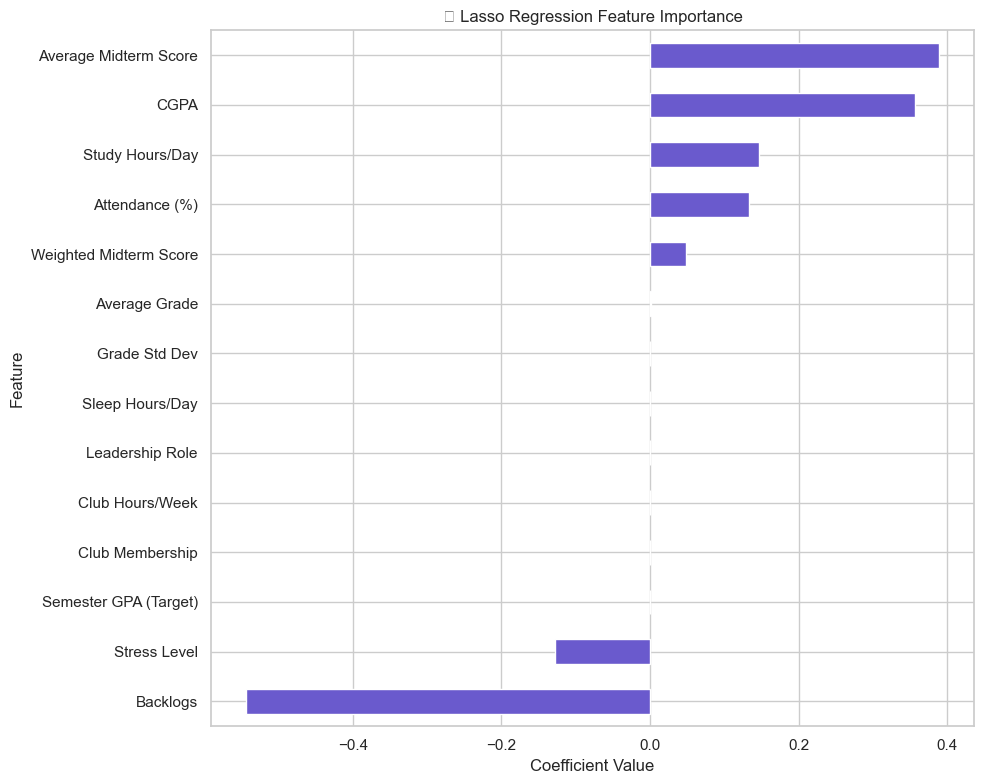

In [19]:
import pandas as pd

coef_df = pd.Series(lasso_cv.best_estimator_.coef_, index=selected_features)
coef_df = coef_df.sort_values()

plt.figure(figsize=(10, 8))
coef_df.plot(kind='barh', color='slateblue')
plt.title("🧠 Lasso Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd

# === Step 1: User Inputs for Subjects and Credits ===
print("Enter subject names (comma separated):")
subjects = input().split(',')

print("Enter corresponding subject credits (comma separated integers):")
subject_credits = list(map(int, input().split(',')))

if len(subjects) != len(subject_credits):
    raise ValueError("Number of subjects and number of credits must match!")

total_credits = sum(subject_credits)

# === Step 2: Load Datasets ===
df = pd.read_csv('predicted_semester_gpa.csv')
gpa_df = pd.read_csv('gpa_predictions_vs_actual.csv')

# === Step 3: Define Grade Band Logic ===
def get_grade_band(mean, std):
    return {
        'S': max(90, mean + 1.5 * std),
        'A': (mean + 0.5 * std, mean + 1.5 * std),
        'B': (mean - 0.5 * std, mean + 0.5 * std),
        'C': (mean - 1.0 * std, mean - 0.5 * std),
        'D': (mean - 1.5 * std, mean - 1.0 * std),
        'E': (mean - 2.0 * std, mean - 1.5 * std),
        'F': (0, mean - 2.0 * std)
    }

grade_points = {'S': 10, 'A': 9, 'B': 8, 'C': 7, 'D': 6, 'E': 5, 'F': 0, 'N': 0}

# === Step 4: Grade Requirement Calculation ===
def analyze_subject_targets(midterm_list, internals, attendance, target_gpa, subject_credits, mean_std_list):
    required_grades = []
    required_term_end = []

    for i in range(len(midterm_list)):
        credit = subject_credits[i]
        midterm = midterm_list[i]
        mean, std = mean_std_list[i]

        if attendance < 3.25:  # < 65% attendance → N grade
            required_grades.append('N')
            required_term_end.append(None)
            continue

        midterm_component = (midterm / 50) * 30
        current_total = midterm_component + internals + attendance
        bands = get_grade_band(mean, std)

        for grade in ['S', 'A', 'B', 'C', 'D', 'E']:
            lower_bound = bands[grade][0] if isinstance(bands[grade], tuple) else bands[grade]
            required_total = max(lower_bound, current_total)

            term_end_required = (required_total - current_total) / 0.3

            if 0 <= term_end_required <= 100:
                required_grades.append(grade)
                required_term_end.append(round(term_end_required, 2))
                break
        else:
            required_grades.append('F')
            required_term_end.append(100.0)

    return required_grades, required_term_end

# === Step 5: Process Data ===
results = []

for idx, row in df.iterrows():
    midterm_scores = list(map(int, row['Midterm Scores (out of 50)'].split(',')))
    internals = 35
    attendance = round((row['Attendance (%)'] / 100) * 5, 2)
    target_gpa = gpa_df.loc[idx, 'Predicted GPA (Lasso Regression)']

    # Placeholder mean/std per subject — ideally load dynamically
    mean_std_list = [(72, 8)] * len(subject_credits)

    grades, term_ends = analyze_subject_targets(
        midterm_scores[:len(subject_credits)], internals, attendance,
        target_gpa, subject_credits, mean_std_list
    )

    results.append({
        'Registration Number': row['Registration Number'],
        'Predicted GPA By Model': target_gpa,
        'Subjects': subjects,
        'Required Grades': grades,
        'Required Term-End Marks': term_ends
    })

# === Step 6: Output ===
output_df = pd.DataFrame(results)
print(output_df.head())
output_df.to_csv('required_grades_with_predicted_gpa.csv', index=False)


Enter subject names (comma separated):


 CAO,MPMC,Java,DAA,Probability


Enter corresponding subject credits (comma separated integers):


 4,4,3,4,4


  Registration Number  Predicted GPA By Model  \
0          23BCE10001                6.801121   
1          23BCE10002                5.918174   
2          23BCE10003                7.107851   
3          23BCE10004                7.308883   
4          23BCE10005                7.112310   

                              Subjects  Required Grades  \
0  [CAO, MPMC, Java, DAA, Probability]  [A, A, A, A, S]   
1  [CAO, MPMC, Java, DAA, Probability]  [A, A, B, B, A]   
2  [CAO, MPMC, Java, DAA, Probability]  [B, A, A, S, A]   
3  [CAO, MPMC, Java, DAA, Probability]  [A, S, B, A, B]   
4  [CAO, MPMC, Java, DAA, Probability]  [A, S, S, B, A]   

               Required Term-End Marks  
0  [81.67, 59.67, 97.67, 99.67, 96.33]  
1  [81.33, 59.33, 88.67, 92.67, 55.33]  
2   [76.17, 82.83, 58.83, 99.5, 74.83]  
3    [87.17, 83.83, 76.5, 77.17, 74.5]  
4    [55.83, 72.5, 90.5, 89.17, 87.83]  
